<a href="https://colab.research.google.com/github/iancaabreu/Personas_Kmeans/blob/main/personas_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Ianca Abreu e Fernando Andrade**



## **1 - Importação das Bibliotecas que serão utilizadas**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
def make_spider(df_plot):
  num_col = df_plot.columns.difference(["cluster"])
  n_cols = df_plot['cluster'].unique().shape[0]
  df_plot[num_col] /= df_plot[num_col].max()
  df_plot = df_plot.fillna(0)

  palette = plt.cm.get_cmap("Set2", len(df_plot.index))

  categories = list(df_plot)[1:]
  N = len(categories)

  angles = [n/float(N)*2*np.math.pi for n in range(N)]
  angles += angles[:1]

  my_dpi = 96
  fig,axes = plt.subplots(df_plot.shape[0] // n_cols, n_cols, figsize=(1500/my_dpi, 1500/my_dpi), dpi=my_dpi, subplot_kw={"projection" : "polar"})
  axes = axes.ravel()

  for idx, ax in enumerate(axes):
    color = palette(idx)

    row = df_plot.iloc[idx]

    ax.set_theta_offset(np.math.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_xticks(angles[:-1], categories, color="grey", size = 7)

    ax.set_rlabel_position(0)
    ax.set_yticks([0.33,0.66, 0.99], ["0.3", "0.6", "1"], color = "grey", size = 10)
    ax.set_ylim(0,1)

    values = row.drop("cluster").values.flatten().tolist()
    values += values[:1]

    ax.plot(angles, values, color = color, linewidth=1.5, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    ax.set_title(f"Persona {row['cluster']}", size=14, color = color, y=1.1)
  plt.tight_layout()
  plt.show()

## **2 - Análise Exploratória dos Dados**

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Prova Aprendizado Maquina/BankChurners.csv")
cols = list(df.columns)
print(cols)

['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']


In [ ]:
df.rename(columns={
    'CLIENTNUM': 'Número_cliente',
    'Attrition_Flag': 'Indicador_atrito',
    'Customer_Age': 'Idade',
    'Gender': 'Gênero',
    'Dependent_count': 'Quantidade_dependente',
    'Education_Level': 'Nível_escolaridade',
    'Marital_Status': 'Estado_civil',
    'Income_Category': 'Categoria_renda',
    'Card_Category': 'Categoria_cartão',
    'Months_on_book': 'Tempo_Relacionamento',
    'Total_Relationship_Count': 'Quantidade_total_relacionamento',
    'Months_Inactive_12_mon': 'Meses_inativos_últimos_12_meses',
    'Contacts_Count_12_mon': 'Quantidade_contatos_em_12_meses',
    'Credit_Limit': 'Limite_crédito',
    'Total_Revolving_Bal': 'Saldo_rotativo_total',
    'Avg_Open_To_Buy': 'Média_abertura_para_compra',
    'Total_Amt_Chng_Q4_Q1': 'Variação_Total_Montante_4º_para_1º_trimestre',
    'Total_Trans_Amt': 'Valor_total_transações',
    'Total_Trans_Ct': 'Quantidade_total_transações',
    'Total_Ct_Chng_Q4_Q1': 'Variação_total_transações_4º_trimestre_para_1º_trimestre',
    'Avg_Utilization_Ratio': 'Taxa_utilização_média',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1': 'Classificador Naive Bayes - Bandeira de Atrito, Categoria do Cartão, Contagem de Contatos 12 meses, Contagem de Dependentes, Nível de Educação, Meses Inativos nos Últimos 12 Meses 1',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2': 'Classificador Naive Bayes - Bandeira de Atrito, Categoria do Cartão, Contagem de Contatos 12 meses, Contagem de Dependentes, Nível de Educação, Meses Inativos nos Últimos 12 Meses 2'
}, inplace=True)

In [ ]:
n_linhas = df.shape[0]
print(f"A base de dados possui {n_linhas} linhas.")

A base de dados possui 10127 linhas.


### **2.1 - Identificação e Conversão das Variáveis Categóricas**

In [ ]:
df.select_dtypes(include='object').head(5)

,Indicador_atrito,Gênero,Nível_escolaridade,Estado_civil,Categoria_renda,Categoria_cartão
0,Existing Customer,M,High School,Married,$60K - $80K,Blue
1,Existing Customer,F,Graduate,Single,Less than $40K,Blue
2,Existing Customer,M,Graduate,Married,$80K - $120K,Blue
3,Existing Customer,F,High School,Unknown,Less than $40K,Blue
4,Existing Customer,M,Uneducated,Married,$60K - $80K,Blue


In [ ]:
df_indicador_atrito = ({'Indicador_atrito': ['Attrited Customer', 'Existing Customer']})

df_indicador_atrito = pd.DataFrame(df)

mapeamento = {'Attrited Customer': 0, 'Existing Customer': 1}

df['Indicador_atrito'] = df['Indicador_atrito'].map(mapeamento)

In [ ]:
df_genero = ({'Gênero': ['F', 'M']})

df_genero = pd.DataFrame(df)

mapeamento = {'F': 0, 'M': 1}

df['Gênero'] = df['Gênero'].map(mapeamento)

In [ ]:
df_escolaridade = ({'Nível_escolaridade': ['Unknown', 'Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate']})

df_escolaridade = pd.DataFrame(df)

mapeamento = {'Unknown': 0, 'Uneducated': 1, 'High School': 3, 'College': 4, 'Graduate': 5, 'Post-Graduate': 6, 'Doctorate': 7}

df['Nível_escolaridade'] = df['Nível_escolaridade'].map(mapeamento)

In [ ]:
df_estado_civil = ({'Estado_civil': ['Unknown', 'Single', 'Married', 'Divorced']})

df_estado_civil = pd.DataFrame(df)

mapeamento = {'Unknown': 0, 'Single': 1, 'Married': 2, 'Divorced': 3}

df['Estado_civil'] = df['Estado_civil'].map(mapeamento)

In [ ]:
df_renda = ({'Categoria_renda': ['Unknown', 'Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +']})

df_renda = pd.DataFrame(df)

mapeamento = {'Unknown': 0, 'Less than $40K': 1, '$40K - $60K': 2, '$60K - $80K': 3, '$80K - $120K': 4, '$120K +': 5}

df['Categoria_renda'] = df['Categoria_renda'].map(mapeamento)

In [ ]:
df_cartao = ({'Categoria_cartão': ['Platinum', 'Gold', 'Silver', 'Blue']})

df_cartao = pd.DataFrame(df)

mapeamento = {'Platinum': 0, 'Gold': 1, 'Silver': 2, 'Blue': 3}

df['Categoria_cartão'] = df['Categoria_cartão'].map(mapeamento)

In [ ]:
df['Gênero'] = df['Gênero'].astype('int64')

In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                                                                                 Non-Null Count  Dtype  
---  ------                                                                                                                                                                                 --------------  -----  
 0   Número_cliente                                                                                                                                                                         10127 non-null  int64  
 1   Indicador_atrito                                                                                                                                                                       10127 non-null  int64  
 2   Idade                                 

In [ ]:
print("Estatísticas Básicas:")
df.describe(percentiles=[.01, .1, .25, .5, .75, .9, .99])

Estatísticas Básicas:


,Número_cliente,Indicador_atrito,Idade,Gênero,Quantidade_dependente,Nível_escolaridade,Estado_civil,Categoria_renda,Categoria_cartão,Tempo_Relacionamento,...,Limite_crédito,Saldo_rotativo_total,Média_abertura_para_compra,Variação_Total_Montante_4º_para_1º_trimestre,Valor_total_transações,Quantidade_total_transações,Variação_total_transações_4º_trimestre_para_1º_trimestre,Taxa_utilização_média,"Classificador Naive Bayes - Bandeira de Atrito, Categoria do Cartão, Contagem de Contatos 12 meses, Contagem de Dependentes, Nível de Educação, Meses Inativos nos Últimos 12 Meses 1","Classificador Naive Bayes - Bandeira de Atrito, Categoria do Cartão, Contagem de Contatos 12 meses, Contagem de Dependentes, Nível de Educação, Meses Inativos nos Últimos 12 Meses 2"
count,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,...,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00,10127.00
mean,739177606.33,0.84,46.33,0.47,2.35,3.31,1.54,2.09,2.92,35.93,...,8631.95,1162.81,7469.14,0.76,4404.09,64.86,0.71,0.27,0.16,0.84
std,36903783.45,0.37,8.02,0.50,1.30,2.09,0.74,1.47,0.33,7.99,...,9088.78,814.99,9090.69,0.22,3397.13,23.47,0.24,0.28,0.37,0.37
min,708082083.00,0.00,26.00,0.00,0.00,0.00,0.00,0.00,0.00,13.00,...,1438.30,0.00,3.00,0.00,510.00,10.00,0.00,0.00,0.00,0.00
1%,708304258.50,0.00,27.00,0.00,0.00,0.00,0.00,0.00,1.00,15.00,...,1438.30,0.00,210.08,0.34,869.26,20.00,0.23,0.00,0.00,0.00
10%,710160513.00,0.00,36.00,0.00,1.00,0.00,1.00,0.00,3.00,26.00,...,1762.00,0.00,683.00,0.53,1501.00,33.00,0.45,0.00,0.00,0.01
25%,713036770.50,1.00,41.00,0.00,1.00,1.00,1.00,1.00,3.00,31.00,...,2555.00,359.00,1324.50,0.63,2155.50,45.00,0.58,0.02,0.00,1.00
50%,717926358.00,1.00,46.00,0.00,2.00,4.00,2.00,2.00,3.00,36.00,...,4549.00,1276.00,3474.00,0.74,3899.00,67.00,0.70,0.18,0.00,1.00
75%,773143533.00,1.00,52.00,1.00,3.00,5.00,2.00,3.00,3.00,40.00,...,11067.50,1784.00,9859.00,0.86,4741.00,81.00,0.82,0.50,0.00,1.00
90%,798512118.00,1.00,57.00,1.00,4.00,5.00,2.00,4.00,3.00,46.00,...,23400.20,2228.40,21964.60,1.00,8212.40,92.00,0.95,0.71,0.99,1.00


### **2.2 - Plots**

In [ ]:
correlation_matrix = df.corr()

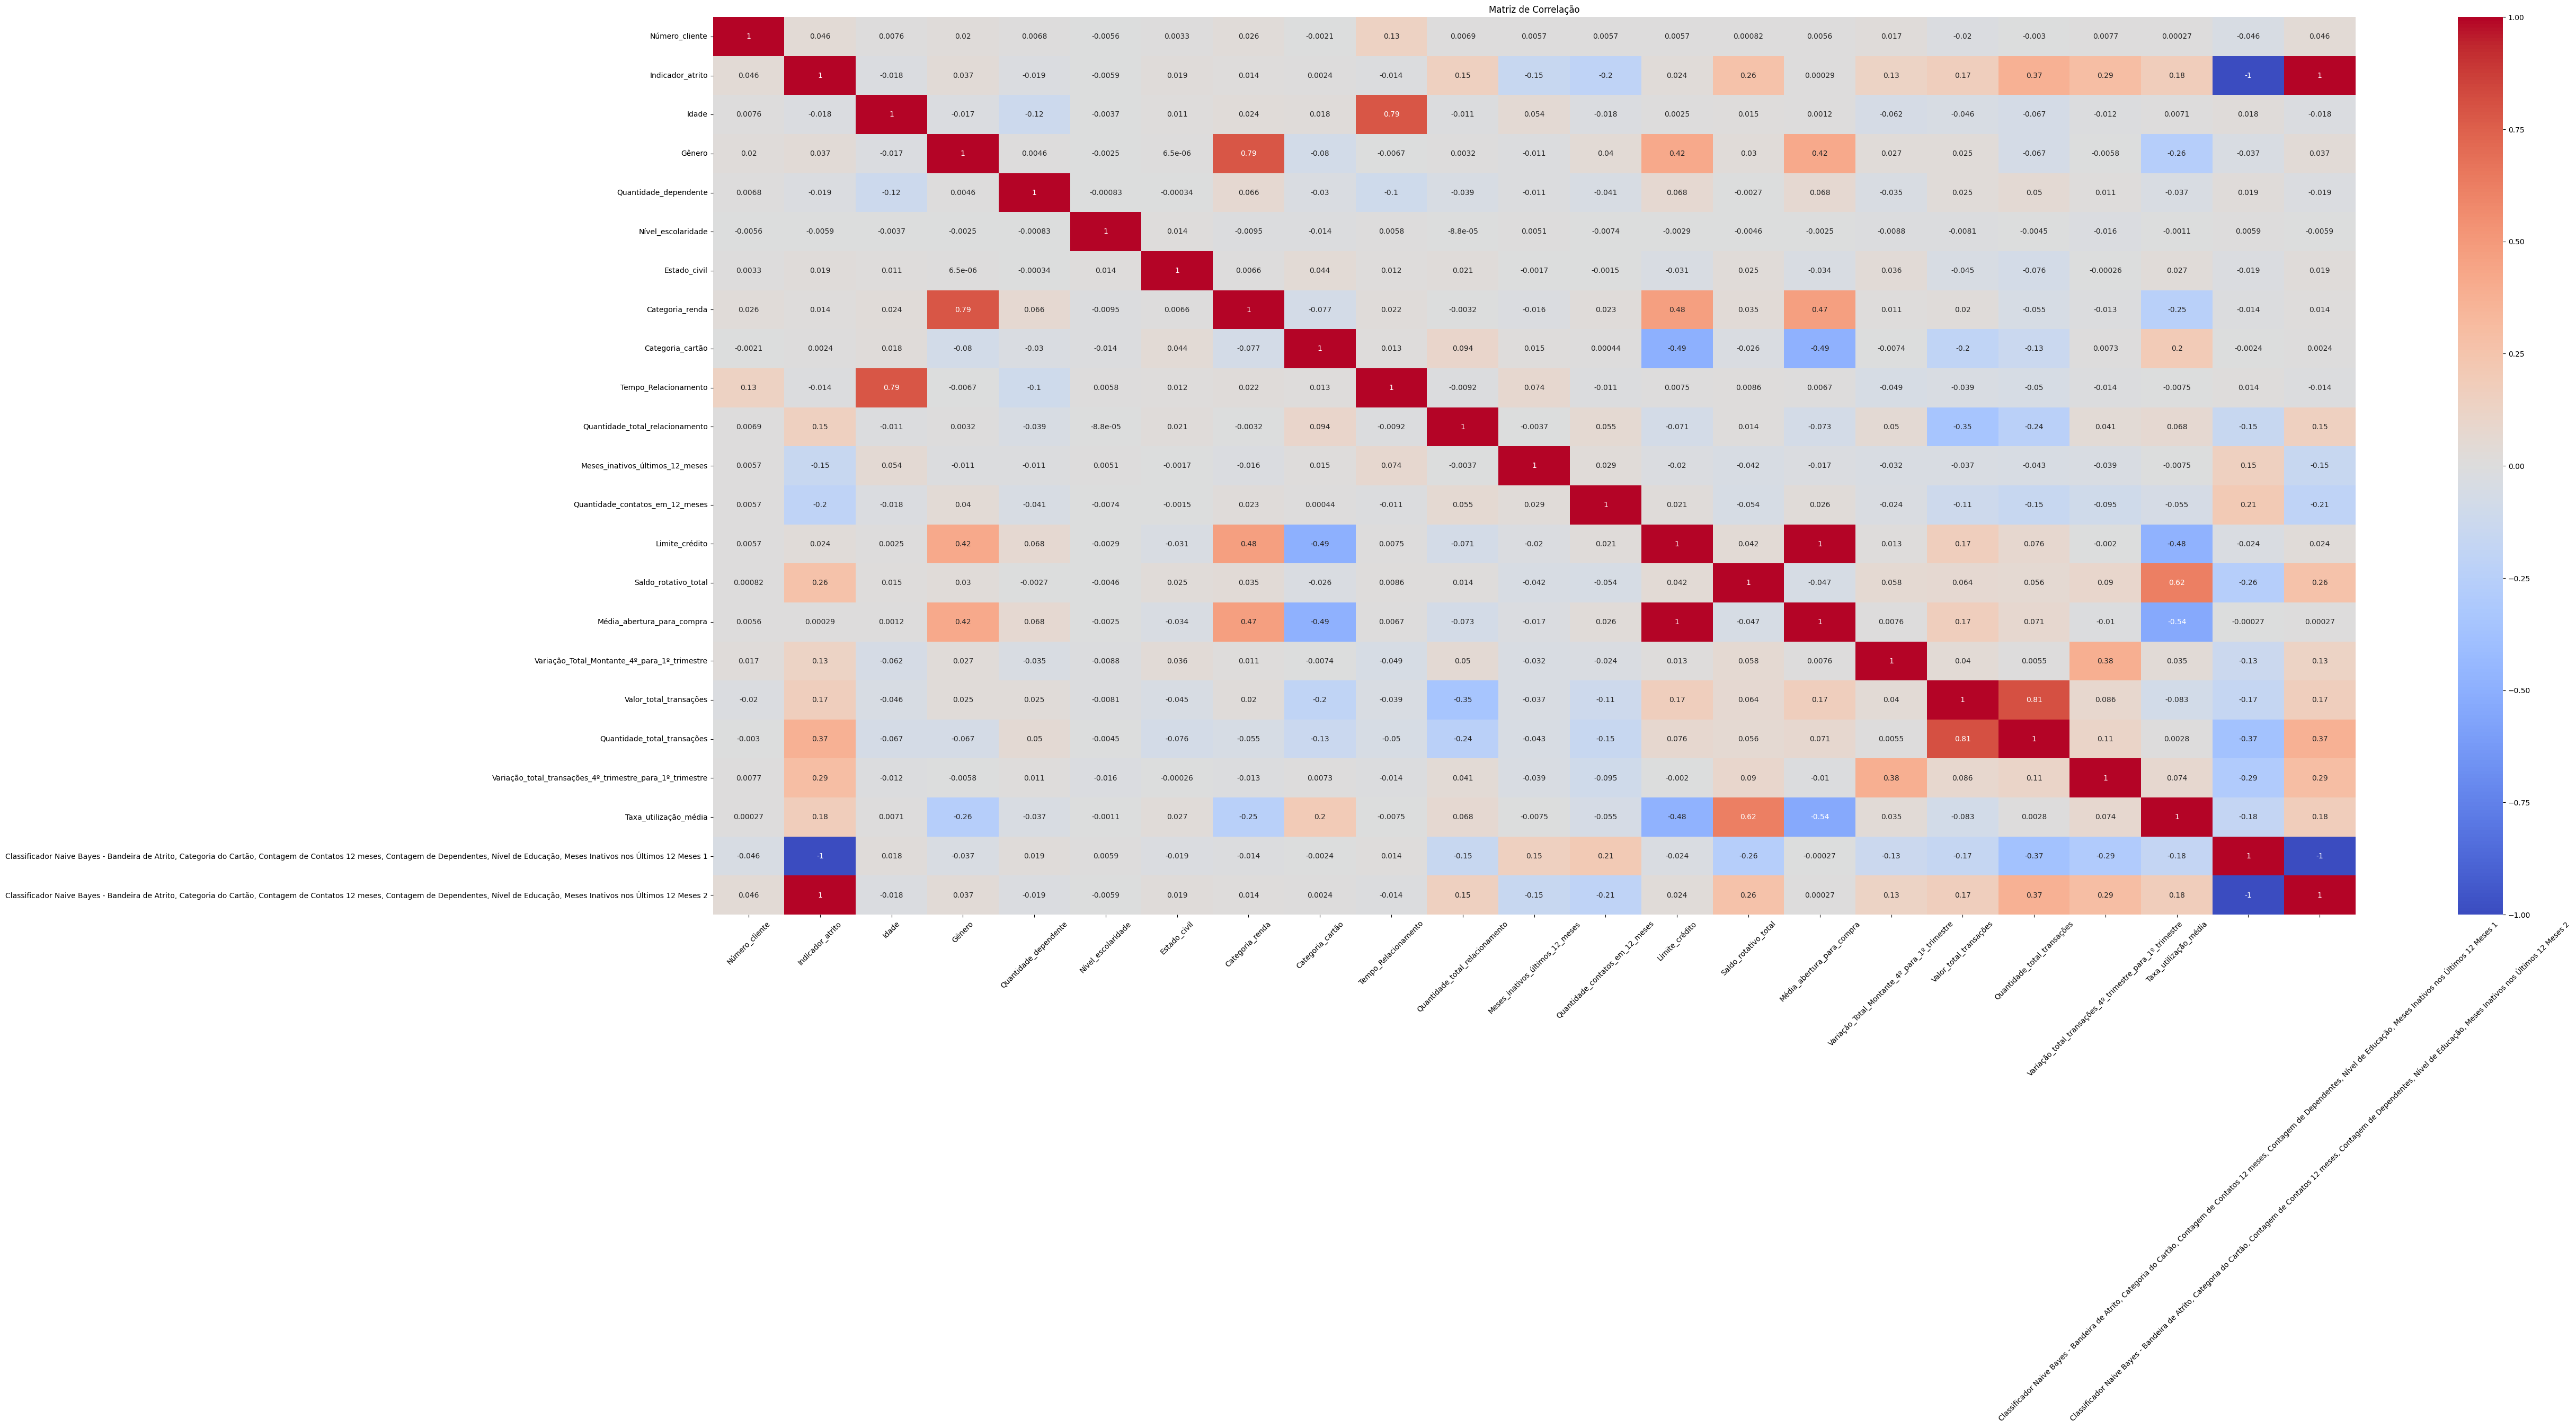

In [ ]:
plt.figure(figsize=(50,22))
chart = sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title("Matriz de Correlação")
plt.show()

In [ ]:
df.columns

Index(['Número_cliente', 'Indicador_atrito', 'Idade', 'Gênero',
       'Quantidade_dependente', 'Nível_escolaridade', 'Estado_civil',
       'Categoria_renda', 'Categoria_cartão', 'Tempo_Relacionamento',
       'Quantidade_total_relacionamento', 'Meses_inativos_últimos_12_meses',
       'Quantidade_contatos_em_12_meses', 'Limite_crédito',
       'Saldo_rotativo_total', 'Média_abertura_para_compra',
       'Variação_Total_Montante_4º_para_1º_trimestre',
       'Valor_total_transações', 'Quantidade_total_transações',
       'Variação_total_transações_4º_trimestre_para_1º_trimestre',
       'Taxa_utilização_média',
       'Classificador Naive Bayes - Bandeira de Atrito, Categoria do Cartão, Contagem de Contatos 12 meses, Contagem de Dependentes, Nível de Educação, Meses Inativos nos Últimos 12 Meses 1',
       'Classificador Naive Bayes - Bandeira de Atrito, Categoria do Cartão, Contagem de Contatos 12 meses, Contagem de Dependentes, Nível de Educação, Meses Inativos nos Últimos 12 Meses 

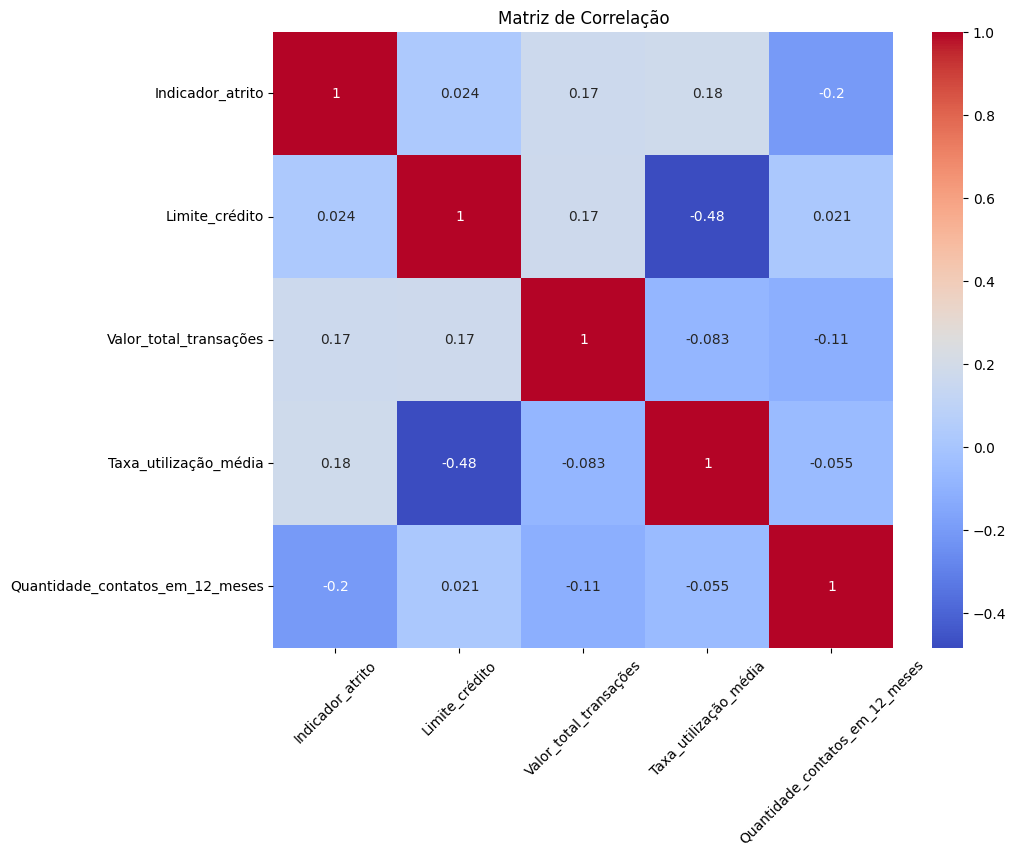

In [ ]:
cols_coorelation = ['Indicador_atrito', 'Limite_crédito', 'Valor_total_transações', 'Taxa_utilização_média', 'Quantidade_contatos_em_12_meses']
correlation_matrix_subset = df[cols_coorelation].corr()

plt.figure(figsize=(10,8))
chart = sns.heatmap(correlation_matrix_subset, annot=True, cmap="coolwarm")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title("Matriz de Correlação")
plt.show()

In [ ]:
col_corte = ['Indicador_atrito', 'Limite_crédito', 'Valor_total_transações', 'Taxa_utilização_média', 'Quantidade_contatos_em_12_meses']

In [ ]:
df[col_corte].describe(percentiles = [.01, .1, .25, .5, .75, .9, .99])

,Indicador_atrito,Limite_crédito,Valor_total_transações,Taxa_utilização_média,Quantidade_contatos_em_12_meses
count,10127.00,10127.00,10127.00,10127.00,10127.00
mean,0.84,8631.95,4404.09,0.27,2.46
std,0.37,9088.78,3397.13,0.28,1.11
min,0.00,1438.30,510.00,0.00,0.00
1%,0.00,1438.30,869.26,0.00,0.00
10%,0.00,1762.00,1501.00,0.00,1.00
25%,1.00,2555.00,2155.50,0.02,2.00
50%,1.00,4549.00,3899.00,0.18,2.00
75%,1.00,11067.50,4741.00,0.50,3.00
90%,1.00,23400.20,8212.40,0.71,4.00


# **3 - Escolha do K clusters Utilizando o Método Elbow**

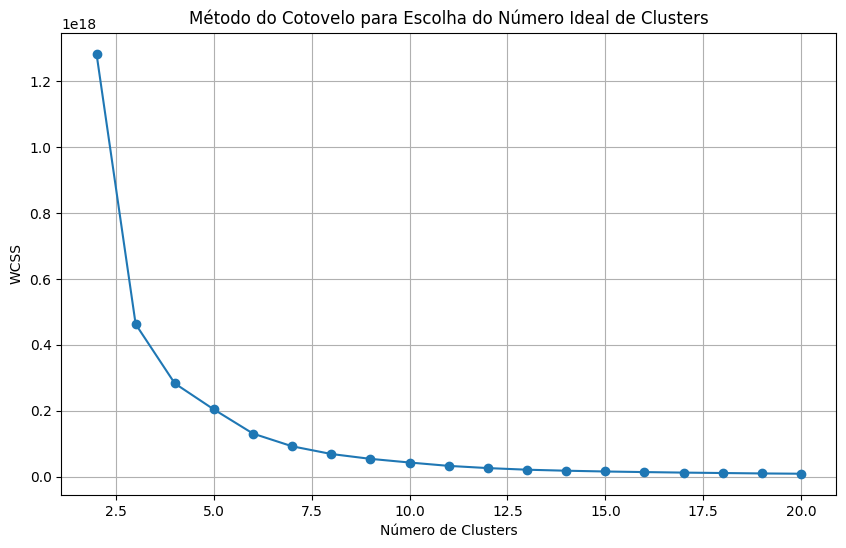

In [ ]:
df_cluster = df.copy()

wcss = []

for i in range(2, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_cluster)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 21), wcss, marker='o')
plt.title('Método do Cotovelo para Escolha do Número Ideal de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [ ]:
df_cluster = df[col_corte].copy()

kmeans = KMeans(n_clusters = 4, random_state = 42, init = 'k-means++', n_init = 1)
kmeans.fit(df_cluster)

df_cluster["cluster"] = kmeans.predict(df_cluster)
df_cluster["cluster"] = [chr(x+65) for x in df_cluster.cluster]

In [ ]:
df_cluster_info = df_cluster.groupby("cluster").median().reset_index()
df_cluster_count = df_cluster.groupby("cluster").count()[col_corte[0]].reset_index()
df_cluster_count.columns = ["cluster", "count"]

df_cluster_table = pd.merge(df_cluster_info, df_cluster_count, how="left", on="cluster")
df_cluster_table

,cluster,Indicador_atrito,Limite_crédito,Valor_total_transações,Taxa_utilização_média,Quantidade_contatos_em_12_meses,count
0,A,1.00,2780.00,3668.00,0.41,2.00,6043
1,B,1.00,17537.50,3456.00,0.07,2.00,1272
2,C,1.00,34516.00,3990.00,0.04,3.00,878
3,D,1.00,8841.00,4695.00,0.15,2.00,1934


## 3.1 - **Normalização das Variáveis**

In [ ]:
scaler_standard = StandardScaler()

df = pd.DataFrame(scaler_standard.fit_transform(df), columns=df.columns)

<Axes: xlabel='f1', ylabel='f2'>

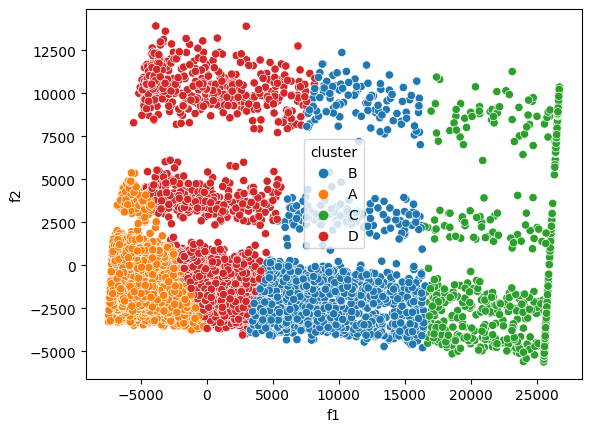

In [ ]:
pca = PCA(n_components=2)
X_transform = pca.fit_transform(df_cluster.drop("cluster", axis=1))
df_X_transform = pd.DataFrame(X_transform, columns = ["f1", "f2"])
df_X_transform["cluster"] = df_cluster["cluster"]


sns.scatterplot(data = df_X_transform, x="f1", y="f2", hue="cluster")

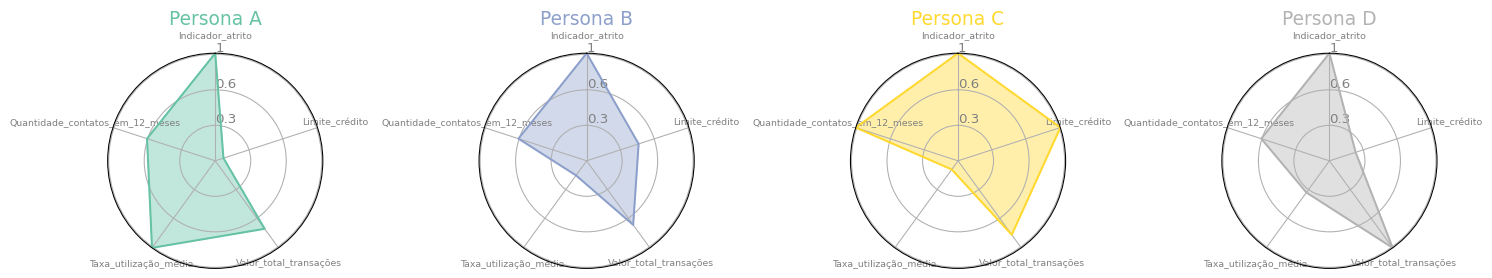

In [ ]:
make_spider(df_cluster_info)

# 4 - **Descrição das Personas**

## **Persona A: Ousado**

## Perfil de cliente com taxa de utilização e valor total de transações altas, porém com baixo limite de crédito. Estratégias para melhor atendê-lo podem incluir personalização de serviços dentro do escopo atual, oferecendo benefícios adicionais para incentivá-lo a explorar novas opções ou produtos e aumentar seu limite crédito e engajamento.

## **Persona B: Moderado**

## Perfil de cliente com baixa taxa de utilização, valor total de transações alta e limite de crédito médio. Preferia operar dentro dos limites dos serviços essenciais, evitando taxas adicionais e mostrando moderação na exploração de novas oportunidades de compra. Para aumentar seu engajamento e taxa de utilização direcionar ofertas de produtos e serviços para diversificar sua carteira.

## **Persona C: Engajado**

# Perfil de cliente engajado, com alto limite de crédito e valor total de transações. Isso sugere uma relação equilibrada e utilização restrita a poucos serviços ou produtos. Para otimizar as oportunidades de expansão de acordo com suas necessidades e objetivos financeiros deve-se ofertar serviços / produtos para diversificar sua utilização.

## **Persona D: Arrojado**

## Perfil de cliente com taxa de utilização praticamente proporcional ao limite crédito e valor total de transações muito alto. Propenso a explorar novas oportunidades financeiras e alta a abertura para compra sugere uma disposição significativa para envolver-se mais profundamente com os serviços oferecidos pelo banco. Estratégias direcionadas para atender às suas necessidades emergentes é personalizar ofertas podem ser eficazes para promover uma relação duradoura.